In [ ]:
import warnings
import numpy as np
import pandas as pd
from sklearn.decomposition import TruncatedSVD
import lightgbm as lgb
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
warnings.filterwarnings('ignore')
from gensim.models import KeyedVectors
from gensim.models import FastText
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir_path = '/content/drive/MyDrive/ML Project/data/'
train_featured = pd.read_csv(data_dir_path + 'train_X_y_features_v1.csv')
test_featured = pd.read_csv( data_dir_path + 'test_X_y_features_v1.csv')
print(train_featured.shape)
print(test_featured.shape)

(1202739, 43)
(300685, 43)


In [ ]:
# Tabluar features
train_X = train_featured.drop(['title','description', 'item_id', 'user_id', 'item_seq_number', 'activation_date', 'image',
       'image_top_1', 'deal_probability'], axis=1)
test_X = test_featured.drop(['title','description', 'item_id', 'user_id', 'item_seq_number', 'activation_date', 'image',
       'image_top_1', 'deal_probability'], axis=1)
train_y = train_featured['deal_probability']
test_y = test_featured['deal_probability']

# Extract embeddings

In [ ]:
# train
train_featured['title'] = train_featured['title'].fillna("")
train_featured['description'] = train_featured['description'].fillna("")
train_featured['text'] = train_featured['title'] + " " + train_featured['description']
train_featured['tokenized_text'] = train_featured['text'].apply(lambda x: x.lower().split())



In [ ]:

# fasttext_model = FastText(
#     sentences=train_featured['tokenized_text'],
#     vector_size=100,
#     window=5,
#     min_count=2,
#     epochs=10
# )

In [ ]:
# fasttext_model.save(data_dir_path+"fasttext_russian_model.bin")

In [ ]:
!wget -O cc.ru.300.vec.gz https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ru.300.vec.gz


--2024-12-02 04:50:36--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ru.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.35.7.128, 13.35.7.38, 13.35.7.82, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.35.7.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1306357571 (1.2G) [binary/octet-stream]
Saving to: ‘cc.ru.300.vec.gz’

cc.ru.300.vec.gz    100%[===================>]   1.22G  29.9MB/s    in 60s     

2024-12-02 04:51:37 (20.6 MB/s) - ‘cc.ru.300.vec.gz’ saved [1306357571/1306357571]



In [ ]:
!gunzip cc.ru.300.vec.gz

In [ ]:
# fasttext_model = FastText.load(data_dir_path+"fasttext_russian_model.bin")
fasttext_model = KeyedVectors.load_word2vec_format('cc.ru.300.vec', binary=False)

In [ ]:
def get_sentence_vector(model, sentence):
    # 直接从模型中提取单词向量
    vectors = [model[word] for word in sentence if word in model]
    if vectors:
        return np.mean(vectors, axis=0)  # 计算平均向量
    else:
        return np.zeros(model.vector_size)  # 如果没有匹配的单词，返回零向量

X_train_only_embeddings = np.array(
    [get_sentence_vector(fasttext_model, text) for text in train_featured['tokenized_text']]
)

X_train_only_embeddings.shape


(1202739, 300)

In [ ]:
X_train_only_embeddings

array([[ 0.06541666, -0.04138333,  0.01128333, ...,  0.06981667,
        -0.08963334,  0.05088333],
       [ 0.04062308, -0.02527692,  0.02324615, ...,  0.03999231,
        -0.06575384,  0.04091538],
       [-0.00534444, -0.06017778, -0.0124    , ...,  0.02761111,
        -0.06554445, -0.20107777],
       ...,
       [ 0.0097625 , -0.01741094,  0.00625156, ...,  0.0188    ,
        -0.03849219, -0.00356562],
       [ 0.01250484, -0.02599355,  0.00839516, ...,  0.03032096,
        -0.04174839,  0.02978064],
       [-0.018125  ,  0.0377    ,  0.09655   , ..., -0.003625  ,
         0.0021    ,  0.024525  ]])

In [ ]:
# train
test_featured['title'] = test_featured['title'].fillna("")
test_featured['description'] = test_featured['description'].fillna("")
test_featured['text'] = test_featured['title'] + " " + test_featured['description']
test_featured['tokenized_text'] = test_featured['text'].apply(lambda x: x.lower().split())



In [ ]:
X_test_only_embeddings = np.array([get_sentence_vector(fasttext_model, text) for text in test_featured['tokenized_text']])


In [ ]:
def fit_lgb(
        train_X, train_y, test_X, test_y, categorical_features,
        params=None,
        num_boost_round=1000,
        early_stopping_rounds=50,
        eval_period=20,
    ):

    if params is None:
        params = {
            'objective': 'regression',
            'metric': 'rmse',
            'boosting_type': 'gbdt',
            'learning_rate': 0.02,
            'num_leaves': 512,
            'max_depth': 20,

            'bagging_seed': 42,
            'bagging_fraction': 0.8,
            'bagging_freq': 5,
            'feature_fraction': 0.8,
            'lambda_l1': 2.25,
            'lambda_l2': 0.015,

            'verbose': -1
        }

    # label encoding for cat var
    for col in categorical_features:
        train_X[col] = train_X[col].astype('category')
        test_X[col] = test_X[col].astype('category')

    # validation set for early stopping
    train_X_split, val_X_split, train_y_split, val_y_split = train_test_split(
        train_X, train_y, test_size=0.2, random_state=42, shuffle=True
    )
    lgb_train = lgb.Dataset(
        train_X_split, label=train_y_split, categorical_feature=categorical_features
    )
    lgb_val = lgb.Dataset(
        val_X_split, label=val_y_split, categorical_feature=categorical_features,
        reference=lgb_train
    )

    callbacks = [
        lgb.early_stopping(stopping_rounds=early_stopping_rounds),
        lgb.log_evaluation(period=eval_period)
    ]

    model = lgb.train(
        params,
        lgb_train,
        num_boost_round=num_boost_round,
        valid_sets=[lgb_train, lgb_val],
        callbacks=callbacks
    )

    preds = model.predict(test_X, num_iteration=model.best_iteration)
    rmse = mean_squared_error(test_y, preds, squared=False)
    print(f"RMSE: {rmse}")

    return model

# LightGBM- Only embeddings 300


In [ ]:
X_train_only_embeddings.shape

(1202739, 300)

In [ ]:
model_1 = fit_lgb(X_train_only_embeddings, train_y, X_test_only_embeddings, test_y, [])


Training until validation scores don't improve for 50 rounds
[20]	training's rmse: 0.250809	valid_1's rmse: 0.25319
[40]	training's rmse: 0.245098	valid_1's rmse: 0.248525
[60]	training's rmse: 0.241181	valid_1's rmse: 0.245636
[80]	training's rmse: 0.238311	valid_1's rmse: 0.243783
[100]	training's rmse: 0.236072	valid_1's rmse: 0.242535
[120]	training's rmse: 0.234209	valid_1's rmse: 0.241659
[140]	training's rmse: 0.232581	valid_1's rmse: 0.241014
[160]	training's rmse: 0.231121	valid_1's rmse: 0.240508
[180]	training's rmse: 0.22978	valid_1's rmse: 0.2401
[200]	training's rmse: 0.228532	valid_1's rmse: 0.239788
[220]	training's rmse: 0.227347	valid_1's rmse: 0.239519
[240]	training's rmse: 0.226214	valid_1's rmse: 0.239279
[260]	training's rmse: 0.225133	valid_1's rmse: 0.239071
[280]	training's rmse: 0.224086	valid_1's rmse: 0.238887
[300]	training's rmse: 0.22307	valid_1's rmse: 0.238716
[320]	training's rmse: 0.222085	valid_1's rmse: 0.238577
[340]	training's rmse: 0.22112	valid

# LightGBM = Embedding with SVD-42d


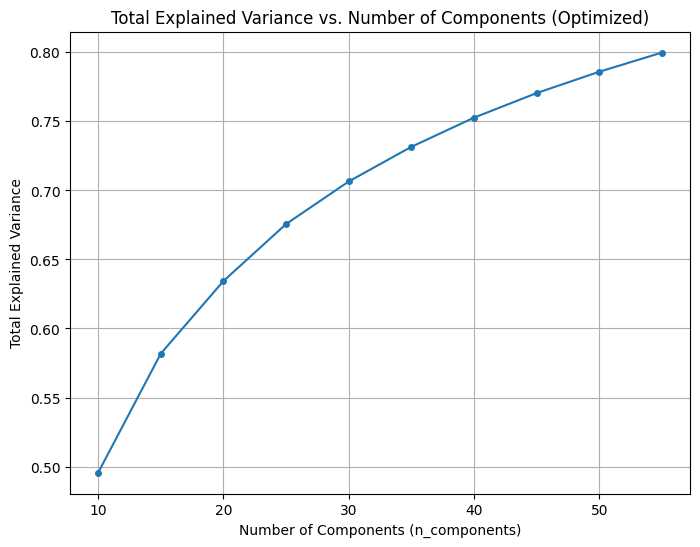

In [ ]:
explained_variances = []
n_components_range = range(10, 60, 5)
for n_components in n_components_range:
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    svd.fit(X_test_only_embeddings)
    explained_variances.append(svd.explained_variance_ratio_.sum())

plt.figure(figsize=(8, 6))
plt.plot(n_components_range, explained_variances, marker='o', linestyle='-', markersize=4)
plt.title("Total Explained Variance vs. Number of Components (Optimized)")
plt.xlabel("Number of Components (n_components)")
plt.ylabel("Total Explained Variance")
plt.grid(True)
plt.show()

In [ ]:
svd = TruncatedSVD(n_components=50, random_state=42)  # reduce dimension to 5d
svd_matrix = svd.fit_transform(X_train_only_embeddings)
print("SVD matrix shape:", svd_matrix.shape)
fasttext_features_train = pd.DataFrame(svd_matrix, columns=[f'svd_{i}' for i in range(50)])

SVD matrix shape: (1202739, 50)


In [ ]:
fasttext_features_train

,svd_0,svd_1,svd_2,svd_3,svd_4,svd_5,svd_6,svd_7,svd_8,svd_9,...,svd_40,svd_41,svd_42,svd_43,svd_44,svd_45,svd_46,svd_47,svd_48,svd_49
0,-0.565544,0.223996,-0.010573,-0.209206,-0.041583,0.231717,-0.205764,0.080843,-0.031737,-0.046010,...,0.006691,-0.009750,0.018076,-0.040986,-0.008322,-0.014621,-0.023466,0.010339,-0.024939,-0.001927
1,-0.569011,0.157657,0.081916,-0.207522,-0.181148,0.185353,-0.043996,0.034164,-0.035225,-0.029618,...,-0.006224,0.036770,0.011804,0.018325,0.007655,-0.002392,0.027915,0.023782,-0.011796,-0.019879
2,-0.726190,0.122073,-0.059864,0.402158,-0.004515,-0.099479,-0.070421,-0.503513,-0.207087,0.124490,...,-0.010621,0.019678,-0.014559,-0.010968,-0.011175,0.025958,0.061752,0.072528,-0.026887,0.014465
3,-0.442801,0.231271,0.046496,-0.160901,0.211666,-0.097255,0.080131,0.029550,0.075218,0.001136,...,0.007752,0.010958,-0.042649,-0.015645,-0.009485,-0.039260,-0.001672,0.036731,-0.005138,-0.014946
4,-0.676612,-0.279189,-0.008875,0.205008,0.060278,0.123265,0.062949,0.039669,0.016941,0.228081,...,0.003091,-0.001625,0.002661,-0.003147,-0.011676,0.027699,0.012001,0.005097,-0.004266,0.009644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1202734,-0.308820,0.073809,-0.002138,0.087189,0.004307,-0.052627,-0.077416,0.028710,-0.023268,0.018951,...,-0.032632,0.014054,-0.001191,0.037130,0.004116,-0.091809,0.062819,0.005311,0.025194,-0.059290
1202735,-0.539368,0.039283,-0.035685,-0.159370,0.101098,-0.105174,-0.067348,0.078271,-0.048918,0.087816,...,0.001675,-0.003575,0.005019,0.009542,0.020366,-0.013738,-0.001712,-0.008889,-0.011912,-0.008033
1202736,-0.518432,0.170643,-0.106815,0.171782,-0.050127,-0.042743,-0.060856,-0.050913,0.017471,0.000682,...,-0.026413,-0.001314,-0.016060,0.020309,-0.010759,-0.015622,-0.013207,0.017230,0.016892,-0.003289
1202737,-0.770976,0.135840,-0.133000,-0.054054,-0.014982,0.070122,-0.012462,-0.099066,0.010337,0.047438,...,0.000259,-0.037508,0.056709,-0.011324,-0.024007,0.011635,0.002853,0.012595,0.029032,-0.000900


In [ ]:
svd = TruncatedSVD(n_components=50, random_state=42)  # reduce dimension to 50
svd_matrix_test = svd.fit_transform(X_test_only_embeddings)
print("SVD matrix shape:", svd_matrix_test.shape)
fasttext_features_test = pd.DataFrame(svd_matrix_test, columns=[f'svd_{i}' for i in range(50)])

SVD matrix shape: (300685, 50)


In [ ]:
fasttext_features_train

,svd_0,svd_1,svd_2,svd_3,svd_4,svd_5,svd_6,svd_7,svd_8,svd_9,...,svd_40,svd_41,svd_42,svd_43,svd_44,svd_45,svd_46,svd_47,svd_48,svd_49
0,-0.565544,0.223996,-0.010573,-0.209206,-0.041583,0.231717,-0.205764,0.080843,-0.031737,-0.046010,...,0.006691,-0.009750,0.018076,-0.040986,-0.008322,-0.014621,-0.023466,0.010339,-0.024939,-0.001927
1,-0.569011,0.157657,0.081916,-0.207522,-0.181148,0.185353,-0.043996,0.034164,-0.035225,-0.029618,...,-0.006224,0.036770,0.011804,0.018325,0.007655,-0.002392,0.027915,0.023782,-0.011796,-0.019879
2,-0.726190,0.122073,-0.059864,0.402158,-0.004515,-0.099479,-0.070421,-0.503513,-0.207087,0.124490,...,-0.010621,0.019678,-0.014559,-0.010968,-0.011175,0.025958,0.061752,0.072528,-0.026887,0.014465
3,-0.442801,0.231271,0.046496,-0.160901,0.211666,-0.097255,0.080131,0.029550,0.075218,0.001136,...,0.007752,0.010958,-0.042649,-0.015645,-0.009485,-0.039260,-0.001672,0.036731,-0.005138,-0.014946
4,-0.676612,-0.279189,-0.008875,0.205008,0.060278,0.123265,0.062949,0.039669,0.016941,0.228081,...,0.003091,-0.001625,0.002661,-0.003147,-0.011676,0.027699,0.012001,0.005097,-0.004266,0.009644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1202734,-0.308820,0.073809,-0.002138,0.087189,0.004307,-0.052627,-0.077416,0.028710,-0.023268,0.018951,...,-0.032632,0.014054,-0.001191,0.037130,0.004116,-0.091809,0.062819,0.005311,0.025194,-0.059290
1202735,-0.539368,0.039283,-0.035685,-0.159370,0.101098,-0.105174,-0.067348,0.078271,-0.048918,0.087816,...,0.001675,-0.003575,0.005019,0.009542,0.020366,-0.013738,-0.001712,-0.008889,-0.011912,-0.008033
1202736,-0.518432,0.170643,-0.106815,0.171782,-0.050127,-0.042743,-0.060856,-0.050913,0.017471,0.000682,...,-0.026413,-0.001314,-0.016060,0.020309,-0.010759,-0.015622,-0.013207,0.017230,0.016892,-0.003289
1202737,-0.770976,0.135840,-0.133000,-0.054054,-0.014982,0.070122,-0.012462,-0.099066,0.010337,0.047438,...,0.000259,-0.037508,0.056709,-0.011324,-0.024007,0.011635,0.002853,0.012595,0.029032,-0.000900


In [ ]:
model_2 = fit_lgb(fasttext_features_train, train_y, fasttext_features_test, test_y, [])


Training until validation scores don't improve for 50 rounds
[20]	training's rmse: 0.252584	valid_1's rmse: 0.254666
[40]	training's rmse: 0.247916	valid_1's rmse: 0.250754
[60]	training's rmse: 0.244734	valid_1's rmse: 0.248299
[80]	training's rmse: 0.242402	valid_1's rmse: 0.246676
[100]	training's rmse: 0.240603	valid_1's rmse: 0.245591
[120]	training's rmse: 0.239108	valid_1's rmse: 0.244801
[140]	training's rmse: 0.237795	valid_1's rmse: 0.244182
[160]	training's rmse: 0.236635	valid_1's rmse: 0.243706
[180]	training's rmse: 0.235574	valid_1's rmse: 0.243327
[200]	training's rmse: 0.234592	valid_1's rmse: 0.243006
[220]	training's rmse: 0.233671	valid_1's rmse: 0.242743
[240]	training's rmse: 0.2328	valid_1's rmse: 0.242512
[260]	training's rmse: 0.231966	valid_1's rmse: 0.242318
[280]	training's rmse: 0.231178	valid_1's rmse: 0.242143
[300]	training's rmse: 0.230414	valid_1's rmse: 0.241988
[320]	training's rmse: 0.229665	valid_1's rmse: 0.241853
[340]	training's rmse: 0.228975	v

# LightGBM- Tabular + SVD embedding


In [ ]:
train_featured.head()

,region,city,parent_category_name,category_name,param_1,param_2,param_3,price,user_type,title,...,description_missing,item_id,user_id,item_seq_number,activation_date,image,image_top_1,deal_probability,text,tokenized_text
0,Омская область,Омск,Бытовая электроника,Настольные компьютеры,NaN,NaN,NaN,50.0,Private,Продам системник,...,0,771fda0ff8ff,969f1c4acd66,18,2017-03-28,5f1a4dc40d333d5cd20c9831553a61053e83ffb156f692...,2789.0,0.76786,Продам системник продам системник на запчасти.,"[продам, системник, продам, системник, на, зап..."
1,Башкортостан,Уфа,Хобби и отдых,Спорт и отдых,Зимние виды спорта,NaN,NaN,500.0,Private,Продам раздвижные коньки на девочку 32-36 разм,...,0,3c296fc97db9,cf345facfe6b,30,2017-03-16,659f553a15733bbc034bc2ea321a8aaa39feaa3fb1e410...,2645.0,0.00000,Продам раздвижные коньки на девочку 32-36 разм...,"[продам, раздвижные, коньки, на, девочку, 32-3..."
2,Нижегородская область,Дзержинск,Для дома и дачи,Растения,NaN,NaN,NaN,80.0,Private,Ромашки и др,...,0,13ecb01f22c1,a4ad6dcc8446,25,2017-03-16,7f5b347e054800f384d22a9959792ab6da7b1442931d03...,406.0,0.12311,Ромашки и др 1фото-ромашка крупноцветковая/\n2...,"[ромашки, и, др, 1фото-ромашка, крупноцветкова..."
3,Челябинская область,Миасс,Личные вещи,Детская одежда и обувь,Для девочек,Верхняя одежда,98-104 см (2-4 года),1500.0,Private,"Зимний комплект Bilemi p,98",...,0,f3a81005ce3d,a41d7a0cd76f,182,2017-03-26,f17dae532061e4a29e25a44fbd90d40ae894c697d636d5...,94.0,0.80323,"Зимний комплект Bilemi p,98 Продам зимний кост...","[зимний, комплект, bilemi, p,98, продам, зимни..."
4,Башкортостан,Уфа,Для дома и дачи,Бытовая техника,Для кухни,Плиты,NaN,18990.0,Shop,Новая духовка Weissgauff самоочистка сенсор га...,...,0,bc91d5eb9229,19757fb0047c,422,2017-03-16,ef7789caae6b81233991c9485cf081bcd6530aa4bd9735...,1852.0,0.00000,Новая духовка Weissgauff самоочистка сенсор га...,"[новая, духовка, weissgauff, самоочистка, сенс..."


In [ ]:
train_featured_with_fasttext = pd.concat([train_featured.reset_index(drop=True), fasttext_features_train], axis=1)
train_featured_with_fasttext = train_featured_with_fasttext.drop(['title', 'description', 'text','tokenized_text'], axis=1)
train_featured_with_fasttext.head()


,region,city,parent_category_name,category_name,param_1,param_2,param_3,price,user_type,region_city,...,svd_40,svd_41,svd_42,svd_43,svd_44,svd_45,svd_46,svd_47,svd_48,svd_49
0,Омская область,Омск,Бытовая электроника,Настольные компьютеры,NaN,NaN,NaN,50.0,Private,Омская область_Омск,...,0.006691,-0.009750,0.018076,-0.040986,-0.008322,-0.014621,-0.023466,0.010339,-0.024939,-0.001927
1,Башкортостан,Уфа,Хобби и отдых,Спорт и отдых,Зимние виды спорта,NaN,NaN,500.0,Private,Башкортостан_Уфа,...,-0.006224,0.036770,0.011804,0.018325,0.007655,-0.002392,0.027915,0.023782,-0.011796,-0.019879
2,Нижегородская область,Дзержинск,Для дома и дачи,Растения,NaN,NaN,NaN,80.0,Private,Нижегородская область_Дзержинск,...,-0.010621,0.019678,-0.014559,-0.010968,-0.011175,0.025958,0.061752,0.072528,-0.026887,0.014465
3,Челябинская область,Миасс,Личные вещи,Детская одежда и обувь,Для девочек,Верхняя одежда,98-104 см (2-4 года),1500.0,Private,Челябинская область_Миасс,...,0.007752,0.010958,-0.042649,-0.015645,-0.009485,-0.039260,-0.001672,0.036731,-0.005138,-0.014946
4,Башкортостан,Уфа,Для дома и дачи,Бытовая техника,Для кухни,Плиты,NaN,18990.0,Shop,Башкортостан_Уфа,...,0.003091,-0.001625,0.002661,-0.003147,-0.011676,0.027699,0.012001,0.005097,-0.004266,0.009644


In [ ]:
train_featured_with_fasttext.to_csv(data_dir_path + 'train_embeddings_fasttext_pretrained_svd.csv', index=False)


In [ ]:
test_featured_with_fasttext = pd.concat([test_featured.reset_index(drop=True), fasttext_features_test], axis=1)
test_featured_with_fasttext = test_featured_with_fasttext.drop(['title', 'description', 'text','tokenized_text'], axis=1)


In [ ]:
test_featured_with_fasttext

,region,city,parent_category_name,category_name,param_1,param_2,param_3,price,user_type,region_city,...,svd_40,svd_41,svd_42,svd_43,svd_44,svd_45,svd_46,svd_47,svd_48,svd_49
0,Красноярский край,Красноярск,Личные вещи,"Одежда, обувь, аксессуары",Аксессуары,NaN,NaN,50000.0,Private,Красноярский край_Красноярск,...,-0.009684,-0.044094,-0.054490,-0.039530,0.000178,0.000128,-0.013025,-0.012938,0.031358,-0.061663
1,Ярославская область,Ярославль,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,21950.0,Company,Ярославская область_Ярославль,...,-0.010442,0.003784,-0.002269,0.011113,-0.019134,0.020261,-0.006821,-0.019856,-0.002894,-0.007247
2,Тюменская область,Тюмень,Личные вещи,"Одежда, обувь, аксессуары",Мужская одежда,Пиджаки и костюмы,52–54 (XXL),2500.0,Private,Тюменская область_Тюмень,...,-0.006240,-0.029800,-0.043902,0.032109,0.004946,-0.018270,-0.096270,0.006296,-0.012686,0.039414
3,Новосибирская область,Новосибирск,Личные вещи,Детская одежда и обувь,Для девочек,Обувь,32,750.0,Company,Новосибирская область_Новосибирск,...,0.007170,0.005267,0.001596,0.003063,-0.003318,0.003420,0.012354,-0.022595,0.003076,-0.000090
4,Краснодарский край,Новороссийск,Личные вещи,"Одежда, обувь, аксессуары",Женская одежда,Платья и юбки,42–44 (S),200.0,Private,Краснодарский край_Новороссийск,...,-0.006155,0.008550,0.040951,-0.001261,-0.028736,-0.002870,-0.035430,-0.023838,-0.005205,0.011777
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300680,Красноярский край,Красноярск,Личные вещи,"Одежда, обувь, аксессуары",Женская одежда,Обувь,37,1000.0,Private,Красноярский край_Красноярск,...,-0.052048,0.082126,-0.012652,-0.069575,-0.039483,0.089687,0.043626,-0.090236,0.053803,-0.003437
300681,Свердловская область,Екатеринбург,Бытовая электроника,Телефоны,LG,NaN,NaN,5500.0,Private,Свердловская область_Екатеринбург,...,0.032150,-0.004460,-0.017118,0.107043,-0.004466,0.007318,0.020556,-0.036633,-0.030722,0.001902
300682,Тульская область,Тула,Личные вещи,Товары для детей и игрушки,Товары для купания,NaN,NaN,150.0,Private,Тульская область_Тула,...,-0.025491,0.022783,0.094369,-0.055403,0.061929,0.003957,-0.005864,0.025352,0.007278,0.038993
300683,Свердловская область,Екатеринбург,Личные вещи,Детская одежда и обувь,Для девочек,Обувь,24,300.0,Private,Свердловская область_Екатеринбург,...,-0.021895,0.039923,-0.002555,-0.012859,-0.037335,-0.000868,0.037115,-0.026503,-0.016589,-0.015563


In [ ]:
test_featured_with_fasttext.to_csv(data_dir_path + 'test_embeddings_fasttext_pretrained_svd.csv', index=False)


In [ ]:
categorical_features = [
    'region', 'city', 'parent_category_name',
    'category_name', 'param_1', 'param_2','param_3', 'user_type',
    'region_city', 'all_category','category_param_1', 'region_category_user', 'city_category_user',
    'title_has_keyword', 'description_has_keyword',
    'price_bin', 'description_missing'
]


In [ ]:
import gc

del train_X
del test_X
del train_featured
del test_featured
gc.collect()

import psutil
print(f"Current memory usage: {psutil.virtual_memory().percent}%")


In [ ]:
train_X_svd_tabular = train_featured_with_fasttext.drop(['deal_probability','item_id','user_id','item_seq_number','activation_date','image','image_top_1'], axis=1)
test_X_svd_tabular = test_featured_with_fasttext.drop(['deal_probability','item_id','user_id','item_seq_number','activation_date','image','image_top_1'], axis=1)
train_y = train_featured_with_fasttext['deal_probability']
test_y = test_featured_with_fasttext['deal_probability']

In [ ]:
test_X_svd_tabular.columns

Index(['region', 'city', 'parent_category_name', 'category_name', 'param_1',
       'param_2', 'param_3', 'price', 'user_type', 'region_city',
       'all_category', 'category_param_1', 'region_category_user',
       'city_category_user', 'category_price_mean', 'category_price_std',
       'category_price_skew', 'city_price_mean', 'city_price_max',
       'city_price_skew', 'title_length', 'description_length',
       'title_word_count', 'description_word_count', 'title_has_keyword',
       'description_has_keyword', 'title_digit_count',
       'description_digit_count', 'description_newline_count', 'price_log',
       'price_bin', 'price_to_category_mean', 'price_to_category_max',
       'description_missing', 'svd_0', 'svd_1', 'svd_2', 'svd_3', 'svd_4',
       'svd_5', 'svd_6', 'svd_7', 'svd_8', 'svd_9', 'svd_10', 'svd_11',
       'svd_12', 'svd_13', 'svd_14', 'svd_15', 'svd_16', 'svd_17', 'svd_18',
       'svd_19', 'svd_20', 'svd_21', 'svd_22', 'svd_23', 'svd_24', 'svd_25',
       '

In [ ]:
model_3 = fit_lgb(train_X_svd_tabular, train_y, test_X_svd_tabular, test_y, categorical_features)

Training until validation scores don't improve for 50 rounds
[20]	training's rmse: 0.242352	valid_1's rmse: 0.245262
[40]	training's rmse: 0.23274	valid_1's rmse: 0.237374
[60]	training's rmse: 0.227011	valid_1's rmse: 0.233341
[80]	training's rmse: 0.223227	valid_1's rmse: 0.231242
[100]	training's rmse: 0.220482	valid_1's rmse: 0.23009
[120]	training's rmse: 0.218326	valid_1's rmse: 0.229481
[140]	training's rmse: 0.216495	valid_1's rmse: 0.229077
[160]	training's rmse: 0.214978	valid_1's rmse: 0.228838
[180]	training's rmse: 0.213672	valid_1's rmse: 0.228669
[200]	training's rmse: 0.212624	valid_1's rmse: 0.228574
[220]	training's rmse: 0.211672	valid_1's rmse: 0.228491
[240]	training's rmse: 0.21079	valid_1's rmse: 0.228425
[260]	training's rmse: 0.209911	valid_1's rmse: 0.22835
[280]	training's rmse: 0.209114	valid_1's rmse: 0.228285
[300]	training's rmse: 0.208378	valid_1's rmse: 0.228239
[320]	training's rmse: 0.207764	valid_1's rmse: 0.228227
[340]	training's rmse: 0.20713	vali